In [1]:
"""Calculate correlations between learned and known features."""

'Calculate correlations between learned and known features.'

In [2]:
# define desired model, model layer, and window size for analysis

model_acc = "6_2" # ["3_6_1", "6_2", "7_1_2", "7_2_2", "7_3_2"]
layer_name = "conv1d2"
known_window = 20 # [10,20,30,40,50]

In [3]:
import os
import numpy as np
import tensorflow as tf
import src.models.utils
import src.utils

class MaskedConv1D(tf.keras.layers.Conv1D):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(filters, kernel_size, **kwargs)
        self.supports_masking = True

In [4]:
alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
weights = {'0': 1, '1': 2, '-': 3}
batch_size = 32

batch_data = src.models.utils.load_data('../../mobidb-pdb_validation/split_data/out/all_seqs.fasta', 
                                        '../../mobidb-pdb_validation/split_data/out/all_labels.fasta')

batches = src.models.utils.BatchGenerator(batch_data, batch_size, alphabet, weights, shuffle=False)

seq_fasta = src.utils.read_fasta('../../mobidb-pdb_validation/split_data/out/all_seqs.fasta')

known_feature_dir = f"../generate_maps/out/window_size{known_window}"

# load in names of known features from first file in known_feature_dir
known_feature_names = np.loadtxt(f"{known_feature_dir}/{os.listdir(known_feature_dir)[0]}", dtype = str, max_rows = 1)

In [5]:
# Extract accessions
protein_acc = []
for accession, _, in seq_fasta:
    protein_acc.append(accession.split("|")[0][1:]) # Keep only acc

In [6]:
# Calculate learned features
model_name = f"mobidb-pdb_cnn_{model_acc}"
model_path = f"../../models/{model_name}/out_model/{model_name}.h5"
model = tf.keras.models.load_model(model_path, custom_objects={"MaskedConv1D":MaskedConv1D})

layer = model.get_layer(layer_name)
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=layer.output)
    
learned_features = []
for input, _, training_weights, in batches:  # Predict method was acting strange, so extract individual batches
    features = feature_extractor(input).numpy()
    features = features[training_weights != 0]  # Drop padding
    learned_features.append(features)

In [7]:
# Construct matrix of learned feature values
learned_feature_array = [array for array in learned_features]
learned_feature_array = np.concatenate(learned_feature_array, axis = 0)
learned_feature_array = learned_feature_array.transpose()

In [8]:
# Load in known features
known_features = []
batch_protein_ct = len(batches)*batch_size
for acc, _, in zip(protein_acc, np.arange(batch_protein_ct)): # Zip removes proteins not included in batches
    acc_path = f"{known_feature_dir}/{acc}_feature_map{known_window}.tsv"
    protein_known_features = np.loadtxt(acc_path, skiprows = 1)
    known_features.append(protein_known_features)

In [9]:
# Construct matrix of known feature values
known_feature_array = [array for array in known_features]
known_feature_array = np.concatenate(known_feature_array, axis = 0)
known_feature_array = known_feature_array.transpose()

In [13]:
# Calculate correlation between known and learned features
corr_matrix = np.corrcoef(learned_feature_array, known_feature_array)
corr_matrix = corr_matrix[:128, -37:]

c:\users\jason hong\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\jason hong\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:>

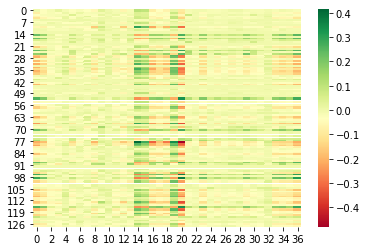

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(test, cmap='RdYlGn')